In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import CenteredNorm

## Import the model

In [2]:
from model.tide import TideFrequency
from model.channel_properties import ChannelProperties
from model.tidal_model import TidalModel, tidal_solvers
from model.salt_model import SaltModel, salt_solvers, characteristic_intrusion_length

## Set the sea side boundary

In [3]:
tide = TideFrequency(
    amplitude=1, # m
    phase=0, # rad
    period_h=12.42, # h
)
sea_concentration = 1 # -

## Set the channel properties

In [4]:
channel_properties = ChannelProperties(
    width=200, # m
    height=10, # m
    length=np.inf, # m
    tidal_averaged_flow=-300, # m^3/s
    drag_coefficient=1*1e-2, # [-]
    tidal_velocity_amplitude=1, # m/s
    diffusion_prefactor=0.0125 # [-]
)

In [5]:
print(f"Diffusion coefficient:\t\t{channel_properties.effective_diffusion_coefficient} [m^2/s]")
print(f"v_0:\t\t\t\t{channel_properties.tidal_averaged_flow / (channel_properties.width * channel_properties.height)} [m/s]")
print(f"Frictionless wave speed:\t{round(channel_properties.frictionless_wave_velocity,2)} [m/s] ({round(channel_properties.frictionless_wave_velocity * 3.6,2)} [km/h])")
print(f"Friction factor:\t\t{channel_properties.friction_factor:e} [-]")

Diffusion coefficient:		500.0 [m^2/s]
v_0:				-0.15 [m/s]
Frictionless wave speed:	9.9 [m/s] (35.66 [km/h])
Friction factor:		8.488264e-04 [-]


## Solve the tidal model

In [6]:
tidal_model = TidalModel(
    properties=channel_properties,
    tide=tide,
)
tidal_solvers.single_channel_tidal_solver(tidal_model=tidal_model)

#### Calculate the result

In [7]:
x_series = np.linspace(0, 200*1e3, 1000)
t_series = np.linspace(0, 2*tide.period_h*60*60, 900)

X, T = np.meshgrid(x_series, t_series)
eta = tidal_model.eta(X, T)
phi = tidal_model.phi(X, T)

#### Plot the result

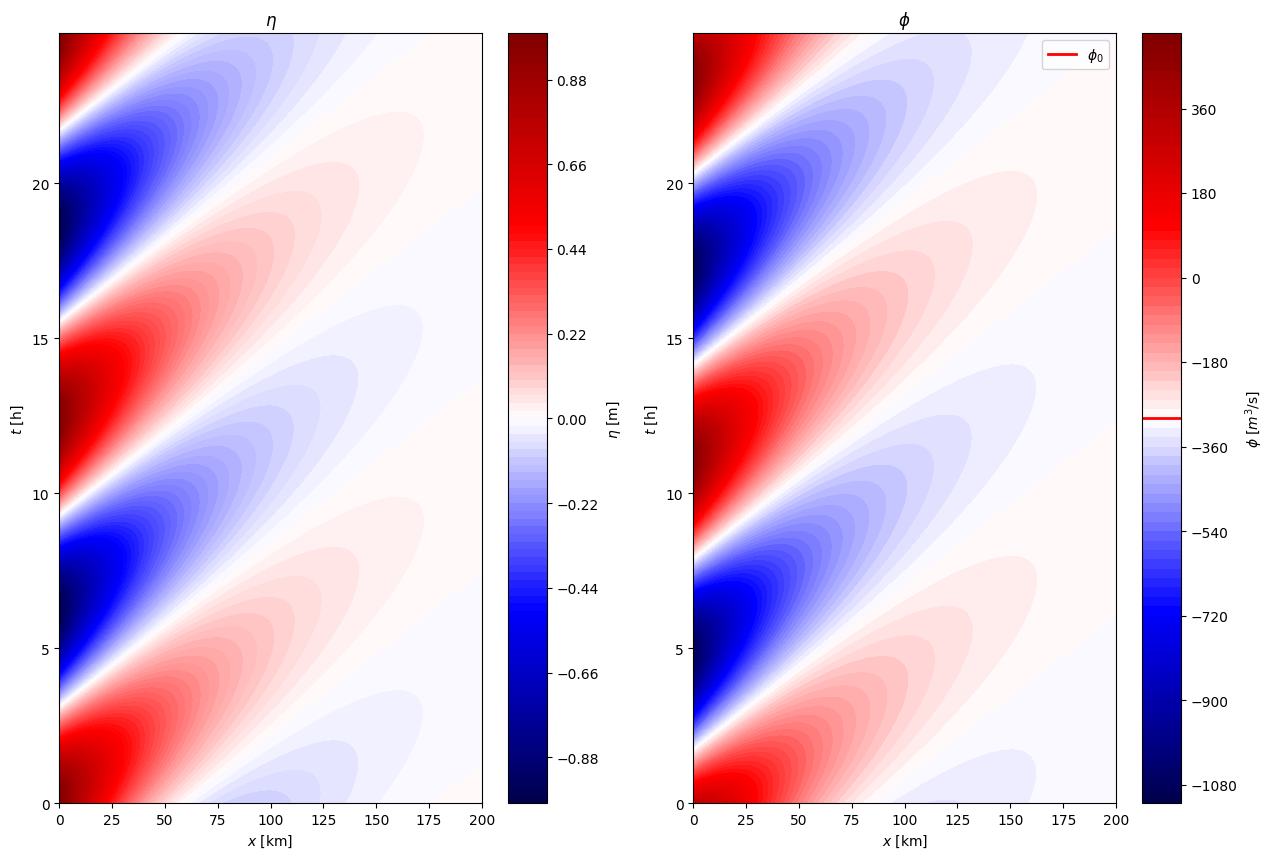

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10), squeeze=False)

# Plot of eta
eta_contour = ax[0, 0].contourf(X/1e3, T/(60*60), eta, cmap="seismic", levels=100)
ax[0, 0].set_xlabel("$x$ [km]")
ax[0, 0].set_ylabel("$t$ [h]")
ax[0, 0].set_title("$\\eta$")
eta_cbar = ax[0, 0].get_figure().colorbar(eta_contour, ax=ax[0, 0])
eta_cbar.set_label("$\\eta$ [m]")

# Plot of phi
phi_contour = ax[0, 1].contourf(X/1e3, T/(60*60), phi, cmap="seismic", levels=100)
ax[0, 1].set_xlabel("$x$ [km]")
ax[0, 1].set_ylabel("$t$ [h]")
ax[0, 1].set_title("$\\phi$")
phi_cbar = ax[0, 1].get_figure().colorbar(phi_contour, ax=ax[0, 1])
phi_cbar.set_label("$\\phi$ [$m^{3}$/s]")
phi_cbar.add_lines(levels=[channel_properties.tidal_averaged_flow], colors=["red"], linewidths=2)
ax[0, 1].legend([Line2D([0], [0], color="red", lw=2)], ["$\\phi_0$"], loc="upper right")

plt.show()

## Solve the salt model

In [9]:
delta_x = 100 #m
channel_L = 200 * 1e3 if channel_properties.length == np.inf else channel_properties.length
channel_m = int(channel_L // delta_x)

salt_model = SaltModel(
    channel_tidal_model=tidal_model,
    num_grid_points=channel_m,
    length=channel_L,
)
salt_solvers.single_channel_salt_solver(salt_model=salt_model, sea_concentration=sea_concentration)

Generating blocks...

  0%|          | 0/1998 [00:00<?, ?it/s]

[DONE]
Combining blocks...[DONE]
Matrix shape: (10000, 10000)
b vector shape: (10000,)
Solving...	[Done] (in 31.20 s)


#### Calculate the salt solution

In [10]:
x_series = np.linspace(0, salt_model.length, salt_model.num_grid_points)
t_series = np.linspace(0, 2*tide.period_h*60*60, 1000)

X, T = np.meshgrid(x_series, t_series)
salt_solution = salt_model.salt_concentration(
    salt_model.i_domain(), t_series
).transpose()

#### Calculate the intrusion length

In [11]:
percentage = 0.1

# Calculate salt intrusion length
salt_average = np.mean(salt_solution, axis=0)
intrusion_index = np.argwhere(salt_average < sea_concentration * percentage)[0][0]
salt_intrusion_length = x_series[intrusion_index]

# Calculate the characteristic intrusion length
intrusion_length_characteristic = characteristic_intrusion_length(
    properties=channel_properties,
    percentage=percentage,
)

print(f"Characteristic intrusion length:\t{intrusion_length_characteristic/1e3:.2f}  km")
print(f"Salt intrusion length: \t\t\t{salt_intrusion_length/1e3:.2f} km")
print("\t\t\t\t\t---------")
print(f"Difference:\t\t\t\t{(intrusion_length_characteristic - salt_intrusion_length)/1e3:.2f} km")

Characteristic intrusion length:	7.68  km
Salt intrusion length: 			10.01 km
					---------
Difference:				-2.33 km


#### Plot the salt solution

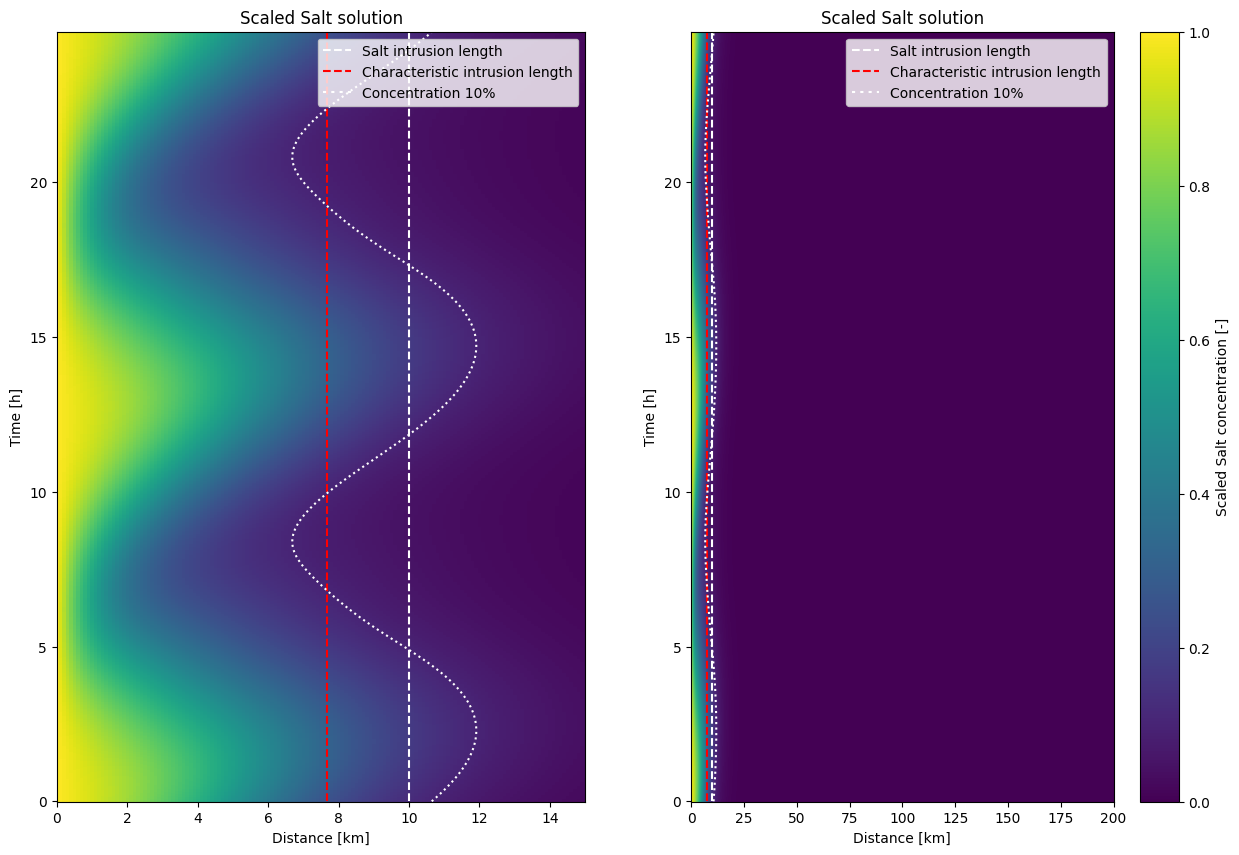

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10), squeeze=False)

x_series_km = x_series / 1e3
t_series_h = t_series / (60 * 60)


for ax_index in range(2):
    im = ax[0, ax_index].pcolormesh(x_series_km, t_series_h, salt_solution)
    ax[0, ax_index].vlines(salt_intrusion_length / 1e3, 0, 2 * tide.period_h, colors='white', linestyles='dashed', label='Salt intrusion length')
    ax[0, ax_index].vlines(intrusion_length_characteristic / 1e3, 0, 2 * tide.period_h, colors='red', linestyles='dashed', label='Characteristic intrusion length')
    countour = ax[0, ax_index].contour(x_series_km, t_series_h, salt_solution, levels=[sea_concentration * percentage], colors='white', linestyles='dotted')
    contour_handle, _ = countour.legend_elements()
    handles, labels = ax[0, ax_index].get_legend_handles_labels()
    ax[0, ax_index].legend(handles + contour_handle, labels + ['Concentration 10%'], loc='upper right')
    ax[0, ax_index].set_title('Scaled Salt solution')
    ax[0, ax_index].set_xlabel('Distance [km]')
    ax[0, ax_index].set_ylabel('Time [h]')

zoom = 1.5
zoom_length = (zoom * salt_intrusion_length if zoom * salt_intrusion_length < channel_L else channel_L) / 1e3
ax[0, 0].set_xlim(0, zoom_length)

cbar = plt.colorbar(im, ax=ax[0, 1])
cbar.set_label('Scaled Salt concentration [-]')
plt.show()

#### Plot the different frequencies

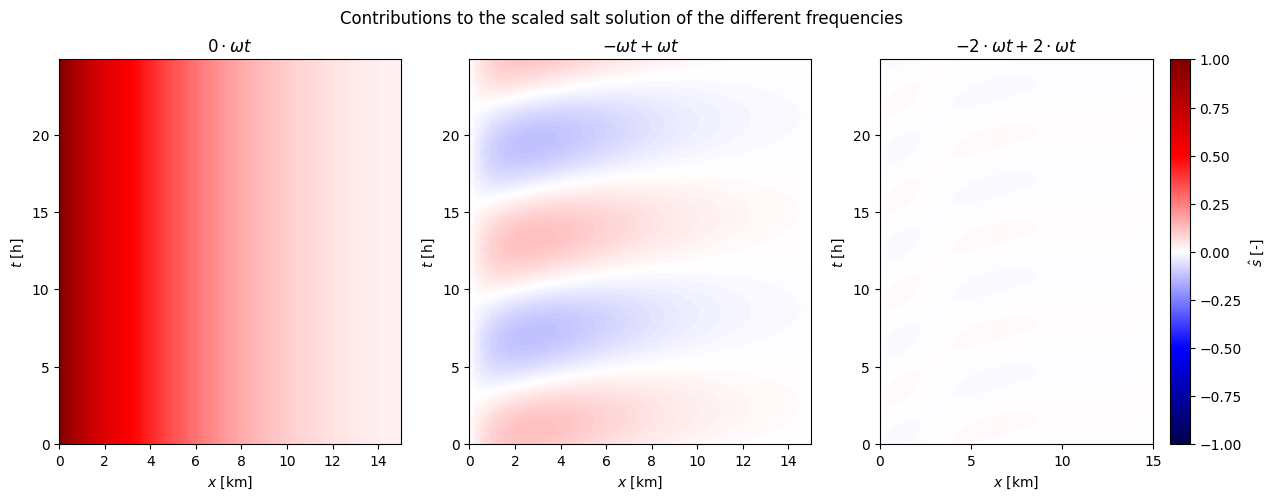

In [13]:
salt_solutions = []
for n in range(3):
    nth_salt_solution = salt_model.salt_n_frequency(
        salt_model.i_domain(), n, t_series
    ).transpose()
    salt_solutions.append(nth_salt_solution)

fig, ax = plt.subplots(1,3, figsize=(15, 5), squeeze=False)
halfrange = np.max([np.max(np.abs(s)) for s in salt_solutions])
zoom = 1.5
zoom_length = (zoom * salt_intrusion_length if zoom * salt_intrusion_length < channel_L else channel_L) / 1e3
for n in range(3):
    im = ax[0, n].pcolormesh(x_series / 1e3, t_series / (60 * 60), salt_solutions[n], cmap="seismic", norm=CenteredNorm(0, halfrange=halfrange))
    if n == 0:
        title = f'${n} \\cdot \\omega t$'
    elif n == 1:
        title = f'$-\\omega t + \\omega t$'
    else:
        title = f'$-{n} \\cdot \\omega t + {n} \\cdot \\omega t$'
    ax[0, n].set_title(title)
    ax[0, n].set_xlabel('$x$ [km]')
    ax[0, n].set_ylabel('$t$ [h]')
    ax[0, n].set_xlim(0, zoom_length)

    # ax.invert_xaxis()
cbar = plt.colorbar(im, ax=ax[0, n])
cbar.set_label('$\\hat{s}$ [-]')
fig.suptitle('Contributions to the scaled salt solution of the different frequencies')
plt.show()